   Alcohol (g)  Protein (g)  Carbs (g)  Fat (g)  Alcohol  Protein    Carbs  \
0         4.98       102.54     327.06    69.32   34.362   410.16  1308.24   
1         0.11        94.71     271.74    64.36    0.759   378.84  1086.96   
2         5.30        81.54     191.36    60.18   36.570   326.16   765.44   
3         0.00       158.60     269.46   109.97    0.000   634.40  1077.84   
4         0.00       188.00     340.10    95.40    0.000   752.00  1360.40   

      Fat  Total energy  Alcoholp   Proteinp     Carbsp       Fatp  
0  623.88      2376.642  1.445821  17.257963  55.045733  26.250483  
1  579.24      2045.799  0.037100  18.517948  53.131319  28.313632  
2  541.62      1669.790  2.190096  19.532995  45.840495  32.436414  
3  989.73      2701.970  0.000000  23.479165  39.890894  36.629940  
4  858.60      2971.000  0.000000  25.311343  45.789297  28.899360  
          Energy percentage  Standard deviation  Standard error
Alcoholp           0.734604            1.023485      

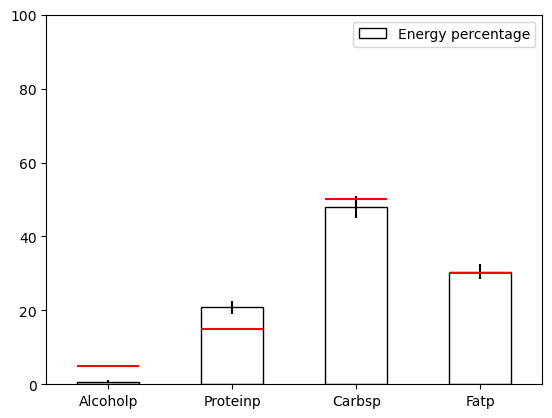

         Date  Energy (kcal)  Alcohol (g)  Caffeine (mg)  Water (g)  \
0  2024-09-17        2912.35          0.0          17.39    2870.71   

   B1 (Thiamine) (mg)  B2 (Riboflavin) (mg)  B3 (Niacin) (mg)  \
0                2.41                  3.68             32.47   

   B5 (Pantothenic Acid) (mg)  B6 (Pyridoxine) (mg)  ...  Completed  Alcohol  \
0                       10.51                  2.81  ...      False      0.0   

   Protein    Carbs     Fat  Total energy  Alcoholp   Proteinp     Carbsp  \
0    753.4  1360.56  858.51       2972.47       0.0  25.345924  45.772035   

        Fatp  
0  28.882041  

[1 rows x 63 columns]
          Energy percentage  Standard deviation  Standard error
Alcoholp           0.000000                 NaN             NaN
Proteinp          25.345924                 NaN             NaN
Carbsp            45.772035                 NaN             NaN
Fatp              28.882041                 NaN             NaN


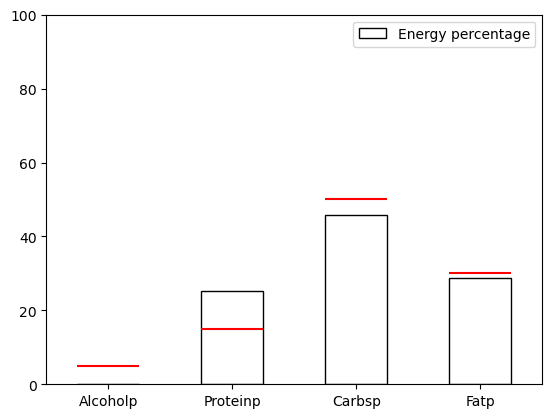

    Date  Energy (kcal)  Alcohol (g)  Caffeine (mg)  Water (g)  \
0  45553        3260.00            0          20.00    2983.75   
1  45554        3363.00            0          20.40    2952.70   
2  45555        3030.84            0          33.75    3245.91   
3  45556        3033.74            0          59.20    3195.00   

   B1 (Thiamine) (mg)  B2 (Riboflavin) (mg)  B3 (Niacin) (mg)  \
0                 2.4                   3.2              31.5   
1                 2.4                   2.9              40.4   
2                 2.8                   2.5              49.5   
3                 1.7                   3.4              28.6   

   B5 (Pantothenic Acid) (mg)  B6 (Pyridoxine) (mg)  ...  Completed  Alcohol  \
0                        10.5                   2.6  ...      False      0.0   
1                        10.5                   3.7  ...      False      0.0   
2                        11.6                   4.2  ...      False      0.0   
3                      

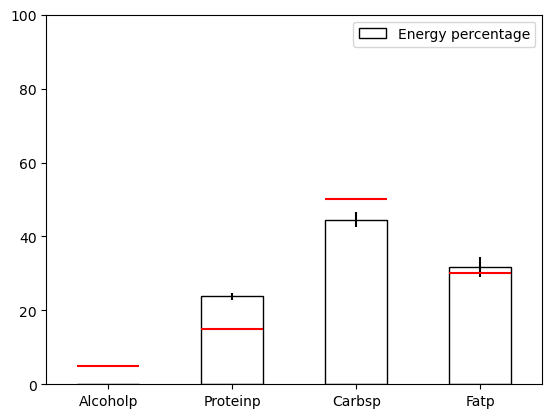

In [4]:
import pandas as pd
import os
from os import path
import numpy as np
import matplotlib.pyplot as plt
import math

def bmr_male(weight,height,age):
    return 88.36 + 13.40 * weight + 4.799 * height - 5.677 * age

def bmr_female(weight,height,age):
    return 447.6 + 9.247 * weight + 3.098 * height - 4.330 * age

def load_dict(dict_file,sep=';'):
    with open(dict_file,'r') as f:
        return dict([(l[0],float(l[1])) for l in [l.split(';') for l in f.readlines()]])

def read_concat_csv(data_dir,seps=('\t',';',',')):
    all_rows = []
    file_row_lengths = {}
    for fname in [f for f in os.listdir(data_dir) if f.endswith('.csv') and not f=='temp.csv']:
        full_fname = path.join(data_dir,fname)
        with open(full_fname,'r') as f:
            lines = [l.strip() for l in f.readlines() if l.strip()]
        if len(lines)<2:
            continue
        
        for sep in seps:
            if len(lines[1].split(sep))>1:
                break
        
        split_rows = [l.split(sep) for l in lines]
        temp = [len(l) for l in split_rows]
        if len(set([len(row) for row in split_rows]))>1:
            raise Exception('File %s has rows with different lengths' % (full_fname,))
        
        header = sep.join(split_rows[0])
        file_row_lengths[full_fname] = len(header)
        all_rows += [sep.join(row) for row in split_rows[1:]]

    if all_rows:
        if len(set(file_row_lengths.values()))>1:
            raise Exception(f'Files have different row lengths: ...')
        
        temp_file = path.join(data_dir,'temp.csv')
        with open(temp_file,'w') as f:
            f.write('\n'.join([header] + all_rows))
            
        return pd.read_csv(temp_file,sep=sep)

def mean_stderr_ref_plot(mean_stderr_df,ref,column_names, mean_std_stderr_columnnames):
    mean,std,stderr = mean_std_stderr_columnnames
    ax = mean_stderr_df.plot(ylim=(0, 100),kind='bar',y=mean, yerr=stderr, rot=0, fill=False)
    width=0.5
    x=0
    for i,c in enumerate(column_names):
        ax.hlines(ref[c], x - width/2, x + width/2, color='red')
        x += 1

TOTAL_ENERGY = 'Total energy'
def analysis(input_df,columns,mean_std_stderr_columnnames):
    mean,std,stderr = mean_std_stderr_columnnames
    df = input_df.copy()
    energy_columns = [c.split()[0] for c in columns]
    energy_percentage_columns = [c+'p' for c in energy_columns]

    # calculate energy, total energy and energy percentage for each column in trial dataset and reference dataset and store in 'energy_columns'
    # energy
    for mc,ec in zip(columns,energy_columns):
        df[ec] = df[mc]*kcal_pr_g[mc]
    
    # total energy
    df[TOTAL_ENERGY] = df[energy_columns].sum(axis=1)

    # and energy percentage
    for ec,epc in zip(energy_columns,energy_percentage_columns):
        df[epc] = 100 * df[ec] / df[TOTAL_ENERGY]

    # mean and std dev
    mean_std_df = df[energy_percentage_columns].describe().loc[['mean','std']].T
    mean_std_df = mean_std_df.rename(columns={'mean':mean,'std': std})
    mean_std_df[stderr] = mean_std_df[std] / math.sqrt(len(mean_std_df))
    
    return df, mean_std_df, [columns, energy_columns, energy_percentage_columns]

try:
    data_dir = path.dirname(path.abspath(__file__))
except:
    # we are in jupyter env.
    data_dir = 'work'
    

ref = load_dict(path.join(data_dir,"nordic-nutrition-recommendations-transposed.csv"))
kcal_pr_g = load_dict(path.join(data_dir,"kcal_pr_g.csv"))

macronutrient_columns = ['Alcohol (g)','Protein (g)','Carbs (g)','Fat (g)']

for sub_dir,subset in (('ffq',[3,4,22,34,35]),('24-h',None),('4-day',None)):
    df = read_concat_csv(path.join(data_dir,sub_dir))
    if subset:
        df = df[df['Stud_Nr'].isin(subset)][macronutrient_columns].apply(pd.to_numeric)

    mean_std_stderr_columnnames = ('Energy percentage','Standard deviation','Standard error')

    result_df, result_mean_std_df, column_names = analysis( df, macronutrient_columns, mean_std_stderr_columnnames)
    print(result_df)
    print(result_mean_std_df)
    mean_stderr_ref_plot(result_mean_std_df, ref, column_names[-1], mean_std_stderr_columnnames)
    plt.show()
